In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import logging
import pickle
import traceback

In [3]:
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GroupKFold
from IPython.display import clear_output
import pytorch_lightning as pl
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
# set the cudnn
torch.backends.cudnn.benchmark=False
torch.backends.cudnn.deterministic=True

In [4]:
from lared_laughter.fusion.dataset import FatherDataset, FatherDatasetSubset, CacheExtractor
from lared_laughter.accel.dataset import AccelExtractor
from lared_laughter.audio.dataset import AudioLaughterExtractor
from lared_laughter.video.dataset import VideoExtractor
from lared_laughter.audio.models.resnet import get_pretrained_body as get_audio_feature_extractor
from lared_laughter.video.models.models import make_slow_pretrained_body as get_video_feature_extractor
from lared_laughter.video.dataset.transforms import get_kinetics_val_transform
from lared_laughter.constants import annot_exp_path, datasets_path
from lared_laughter.utils import load_examples
from lared_laughter.fusion.train import System, train, test
from lared_laughter.fusion.utils import make_table, make_dataframe, make_heatmap
from lared_laughter.fusion.dataset.extractors import SegMaskExtractor

In [5]:
def do_cross_validation(do_train, ds, input_modalities, model_label_modality, test_label_modality,
    seed, task='classification', prefix=None, first_fold_only=False, deterministic=False):
    
    cv_splits = list(GroupKFold(n_splits=10).split(range(len(ds)), groups=ds.get_groups()))
    
    if first_fold_only:
        # only do first fold
        cv_splits = [cv_splits[0]]
    else:
        # skip the first fold
        cv_splits = cv_splits[1:]

    all_results = []
    for f, (train_idx, test_idx) in enumerate(cv_splits):
        # load feature caches for fold f
        ds.load_caches(f)
        train_ds = FatherDatasetSubset(ds, train_idx, eval=False)
        test_ds = FatherDatasetSubset(ds, test_idx, eval=True)

        weights_path = os.path.join(
            'weights',
            task,
            f'I{"-".join(input_modalities)}_L{model_label_modality}_fold{f}.ckpt'
        )

        pl.utilities.seed.seed_everything(seed+f+734890573)
        if do_train:
            trainer = train(f, train_ds, test_ds, input_modalities,
                prefix = prefix + f'_fold{f}' if prefix else None,
                task=task,
                eval_every_epoch=first_fold_only,
                deterministic=deterministic,
                weights_path=weights_path)
            model = trainer.model
        else:
            model = System.load_from_checkpoint(checkpoint_path=weights_path)

        # ensures that the testing is reproducible regardless of training
        pl.utilities.seed.seed_everything(seed+f+2980374334)
        fold_outputs = test(f, model, test_ds, prefix = prefix + f'_fold{f}' if prefix else None,)
        all_results.append(fold_outputs)
        
        # store the cache to disk
        if do_train:
            ds.store_caches(clear=True)

        clear_output(wait=False)

    outputs = [r['proba'].numpy() for r in all_results]
    indices = [r['index'].numpy() for r in all_results]
    metrics = [r['metric'] for r in all_results]
    return metrics, outputs, indices

In [6]:
def do_run(task, examples, input_modalities, model_label_modality, test_label_modality,
    do_train=True, first_fold_only=False, deterministic=True, prefix=''):
    ''' train = True will train the models, and requires 
            model_label_modality = test_label_modality
        train = False will load weights to test the models and does not require
            model_label_modality = test_label_modality
    '''
    if do_train:
        assert model_label_modality == test_label_modality

    if task == 'classification':
        label_column = 'pressed_key'
    elif task == 'regression':
        label_column = 'intensity'
    elif task == 'segmentation':
        label_column = None
    else:
        raise ValueError()

    print(f'Using {len(examples)} examples')

    # create the feature datasets
    extractors = {}
    if 'audio' in input_modalities:
        audios_path = os.path.join(datasets_path, "loose", "lared_audios.pkl")
        extractors['audio'] = CacheExtractor(
            enable=False,
            model = get_audio_feature_extractor().cuda(),
            extractor = AudioLaughterExtractor(audios_path, min_len=1.5, max_len=1.5, n_jobs=10),
            cache_path=f'./cache_seg/Iaudio_L{test_label_modality}_cache{"_first" if first_fold_only else ""}'
        )
    if 'video' in input_modalities:
        videos_path = '/home/jose/data/lared_video/video'
        pool = False if task == 'segmentation' else True
        extractors['video'] = CacheExtractor(
            enable=False,
            model = get_video_feature_extractor(pool=pool).cuda(),# if do_train else None,
            extractor = VideoExtractor(videos_path, transform=get_kinetics_val_transform(8, 256, False), n_jobs=1),
            cache_path=f'./cache_seg/Ivideo_L{test_label_modality}_cache{"_first" if first_fold_only else ""}'
        )
    if 'accel' in input_modalities:
        accel_ds_path = os.path.join(datasets_path, 'loose', 'accel_long.pkl')
        extractors['accel'] = AccelExtractor(accel_ds_path, min_len=1.5, max_len=1.5)

    if task == 'segmentation':
        annot_path = os.path.join(annot_exp_path, 'processed', 'continuous_corrected.pkl')
        label_extractor = SegMaskExtractor(annot_path, min_len=1.5, max_len=1.5)
    else:
        label_extractor = None

    ds = FatherDataset(examples, extractors, 
        label_column=label_column,
        label_extractor=label_extractor,
        id_column='hash', )
    assert len(ds) == 1318
        
    seed = 22
    
    metrics, probas, indices = do_cross_validation(
        do_train,
        ds,
        first_fold_only=first_fold_only,
        input_modalities=input_modalities,
        model_label_modality = model_label_modality, 
        test_label_modality = test_label_modality,
        task=task,
        deterministic=deterministic,
        seed=seed,
        prefix=f'{prefix}I{"-".join(input_modalities)}_L{model_label_modality}_T{test_label_modality}')

    torch.cuda.empty_cache()

    return {
        'metrics': metrics,
        'probas': probas,
        'indices': indices,
        'seed': seed
    }

In [7]:
def get_table(task, first_fold_only=False, do_train=True, deterministic=True):
    examples = load_examples(os.path.join(annot_exp_path, 'processed', 'examples_without_calibration.csv'))

    all_input_modalities = [
        # ('audio', 'video', 'accel'),
        # ('video',),
        # ('accel',),
        # ('audio',),        
        # ('video','accel'),
        ('audio', 'video'),
    ]    

    res = {}
    for input_modalities in all_input_modalities:#[('accel',), ('audio',), ('video',)]:
        input_modality_res = {}

        for model_modality in ['audio', 'video', 'av']:

            input_modality_res[model_modality] = {}
            test_modalities = [model_modality] if do_train else ['audio', 'video', 'av']

            for test_modality in test_modalities:
                filtered_examples = examples[examples['condition'] == test_modality].reset_index()
                run_results = do_run(
                    task,
                    filtered_examples, 
                    input_modalities, 
                    model_label_modality=model_modality,
                    test_label_modality=test_modality,
                    do_train=do_train,
                    first_fold_only=first_fold_only,
                    prefix=task[:3]+'_',
                    deterministic=deterministic)
                input_modality_res[model_modality][test_modality] = [run_results]

        res['-'.join(input_modalities)] = input_modality_res
    return res

In [8]:
try:
    res = get_table(task='segmentation', first_fold_only=False, do_train=True, deterministic=False)
except Exception:
    print(traceback.format_exc())

In [9]:
pickle.dump(res, open('results/segmentation2.pkl', 'wb'))

In [18]:
res2 = {}
res2['accel'] = res['accel']
res2['audio'] = res['audio']
res2['video'] = res['video']
res2['audio-video-accel'] = res['audio-video-accel']

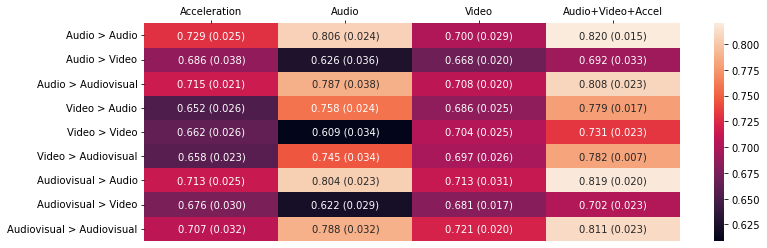

In [22]:
fig = make_heatmap(res2)